In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
from selenium import webdriver

In [2]:
df_train = pd.read_csv('./train_data.csv')
df_test = pd.read_csv('./test_data.csv')

/tmp/ipykernel_18145/1694794678.py:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train = pd.read_csv('./train_data.csv')


In [3]:
### Convert to int16 to save memory
df_train['overall'] = df_train['overall'].astype('int16') 
### Convert to datetime type
df_train['reviewTime'] =  pd.to_datetime(df_train['reviewTime'])
df_test['reviewTime'] =  pd.to_datetime(df_test['reviewTime'])
### Drop few rows so that data becomes cleaner (This is a minor change.)
df_train = df_train.dropna(subset=['summary', 'reviewerName'])
### Sort by datetime (reviewTime column)
df_train.sort_values(by='reviewTime', axis=0, inplace=True, ascending=True)
df_test.sort_values(by='reviewTime', axis=0, inplace=True, ascending=True)
### Max and Min date range
print(f"Max date : {df_train['reviewTime'].max()}")
print(f"Min date : {df_train['reviewTime'].min()}")

### Convert vote column
### For train
df_train['vote'] = pd.to_numeric(df_train['vote'], errors='coerce', downcast='integer')
df_train['vote'] = df_train['vote'].fillna(pd.NA).astype('Int32')
### For test
df_test['vote'] = pd.to_numeric(df_test['vote'], errors='coerce', downcast='integer')
df_test['vote'] = df_test['vote'].fillna(pd.NA).astype('Int32')

Max date : 2018-10-03 00:00:00
Min date : 2016-01-01 00:00:00


<div style="direction:rtl; font-size: 25px; background-color: cyan; color:black; padding:30px 0"> بخش ۱) تجزیه و تحلیل اولیه از داده‌ها </div>

<div style="direction:rtl; font-size: 25px; background-color: green; color:black;"> قسمت اول </div>

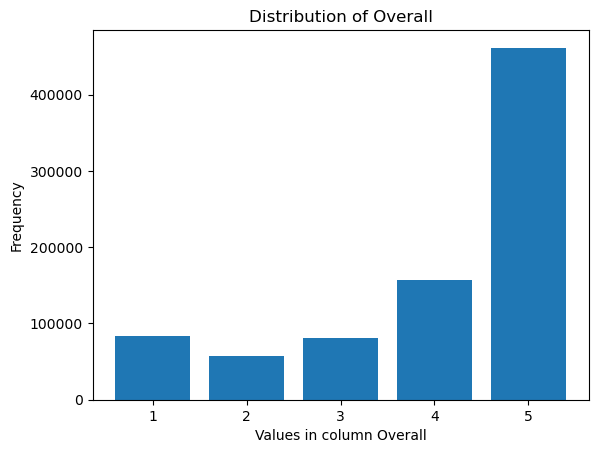

In [4]:
### Plot distrubution of overall column 
overall_values = df_train['overall'].value_counts().sort_index(ascending=False)
plt.xlabel('Values in column Overall')
plt.ylabel('Frequency')
plt.title('Distribution of Overall')
plt.bar(overall_values.index, overall_values.values)
plt.show()

<div style="direction:rtl; font-size: 25px; background-color: green; color:black;"> قسمت دوم </div>

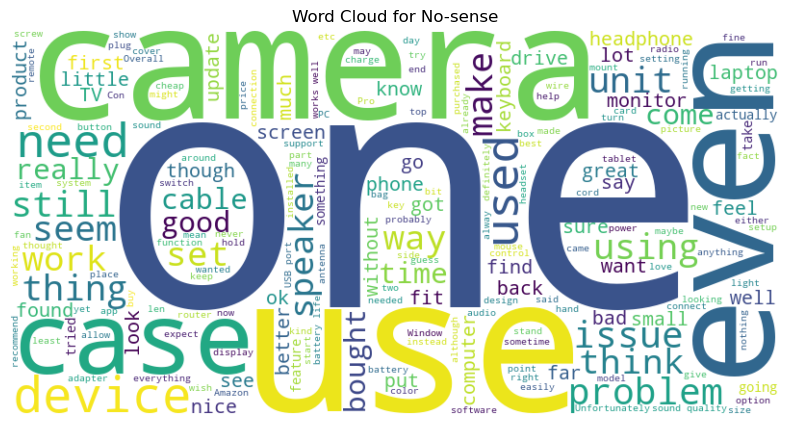

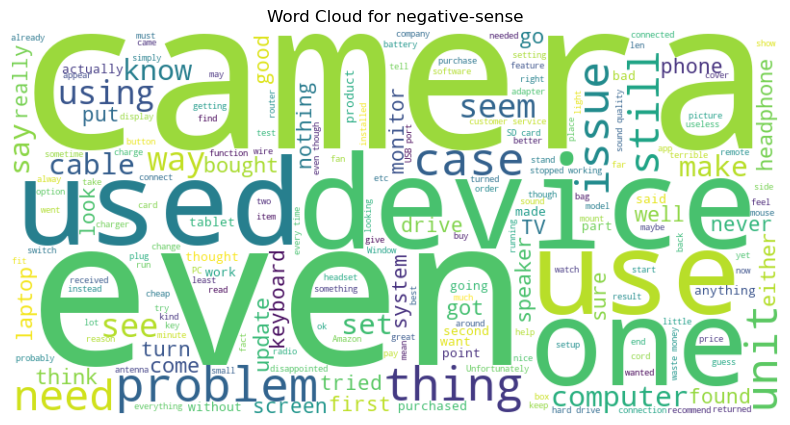

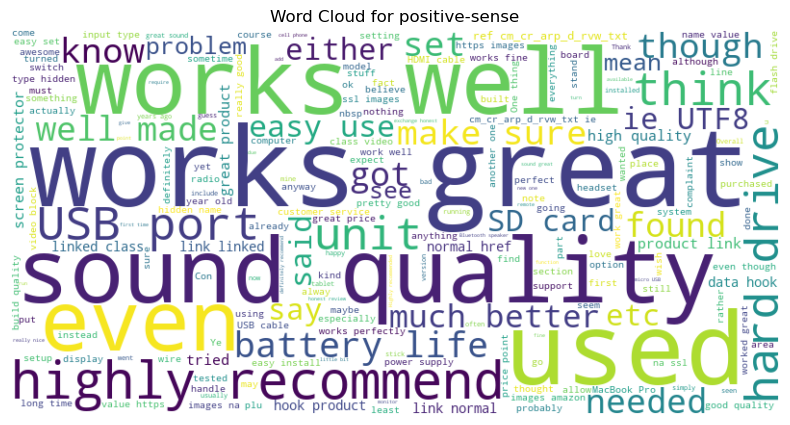

In [5]:
# ### You only need to run this once . Uncomment it again afterwards.
# # nltk.download('stopwords')

### Define 3 groups
group_labels = {
    4: 'positive-sense',
    5: 'positive-sense',
    3: 'No-sense',
    2: 'negative-sense',
    1: 'negative-sense'
}
### Create a copy just to be sure
df_cloud = df_train.copy()

### Filter the DataFrame based on the custom group labels
df_cloud['group'] = df_cloud['overall'].map(group_labels)

### Just to be sure of results
### Filter out rows with no valid group
df = df_cloud[df_cloud['group'].notna()]

### Define a function to remove stop words from text string
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

### Apply remove_stopwords method to reviewText column
df_cloud['reviewText'] = df_cloud['reviewText'].apply(remove_stopwords)

### Plot word CLoud for each group
for group, data in df_cloud.groupby('group'):
    text = ' '.join(data['reviewText'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {group}')
    plt.axis('off')
    plt.show()

<div style="direction:rtl; font-size: 25px; background-color: green; color:black;"> قسمت سوم </div>

In [6]:
top_10_votes = df_train.sort_values(by='vote', ascending=False)
top_10_votes[['reviewerName', 'vote']].head(10)

,reviewerName,vote
561262,David H,982
521251,VermontGuy,971
537656,Chris Upton,970
137082,Chip Ahoy,923
173550,Tech Dude,920
703727,R. Voorhees,919
711265,Patrick,912
264627,Obi Wan,909
622020,Benson Leung,889
648021,Apollo Clark,833


<div style="direction:rtl; font-size: 25px; background-color: green; color:black;"> قسمت چهارم </div>

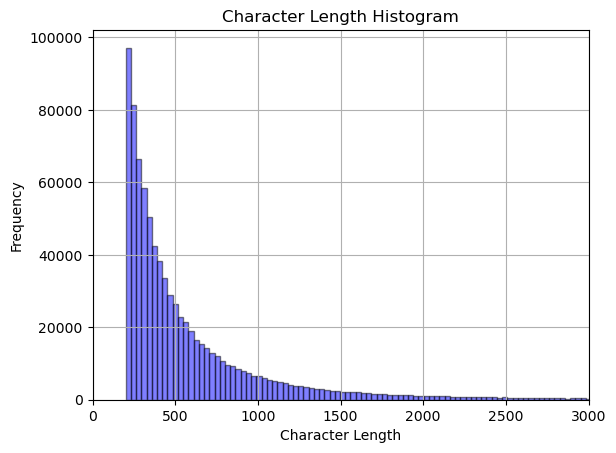

In [7]:
### Calculate bins using square root
num_bins = int(np.sqrt(len(df_train['reviewText'])))
### Plot
plt.hist(df_train['reviewText'].apply(len), bins=num_bins, alpha=0.5, color='b', edgecolor='black')
plt.title('Character Length Histogram')
plt.xlabel('Character Length')
plt.ylabel('Frequency')

### Limit x-axis
plt.xlim(0, 3000)

plt.grid(True)
plt.show()

<div style="direction:rtl; font-size: 25px; background-color: green; color:white;"> با توجه به نمودار هستوگرام بدست امده ، پیشنهاد میشود محدودیت ۲۰۰۰ تایی برای تعداد کاراکترهای نظرات در نظر گرفته شود چراکه اکثریت نظرات کمتر از این تعداد کاراکتر داشتند.  </div>

<div style="direction:rtl; font-size: 25px; background-color: green; color:black;"> قسمت پنجم </div>

In [8]:
### Groupby product string ID
top_10_products = df_train[df_train['overall'] == 5].groupby('asin').size().reset_index(name='count')
### Sort them by their count 
top_10_products = top_10_products.sort_values(by='count', ascending=False)
top_10_products = top_10_products[:10].reset_index(drop=True)
top_10_products

,asin,count
0,B010OYASRG,1162
1,B00L0YLRUW,659
2,B01DA0YCNC,600
3,B000VS4HDM,598
4,B0043T7FXE,552
5,B00OBRE5UE,529
6,B00S9SGNNS,471
7,B000WYVBR0,448
8,B00P7EVST6,433
9,B00OAJ412U,431


In [9]:
from time import sleep
from selenium.webdriver.common.by import By

### Path to your selenium driver
driver_path = '/usr/local/bin/geckodriver'

driver = webdriver.Firefox(executable_path=driver_path)
brands = []
models = []

for product_id in top_10_products["asin"]:
    driver.get(f"https://www.amazon.com/dp/{product_id}")

    ### Model name
    model_name = driver.find_element_by_id('productTitle').text

    ### Brand name
    inner_html = "Brand" 
    xpath_expression = f"//span[contains(., '{inner_html}')]"
    span_element = driver.find_element_by_xpath(xpath_expression)
    parent_element = span_element.find_element_by_xpath('..')
    sibling_element = parent_element.find_element_by_xpath('following-sibling::*')
    child_element = sibling_element.find_element_by_xpath('.//*')
    inner_html = child_element.get_attribute('innerHTML')
    brand_name = inner_html

    try:
        pass
    except NoSuchElementException:
        button = driver.find_element_by_xpath('/html/body/div[1]/header/div/div[4]/div[1]/div/div/div[3]/span[1]/span/input')
        button.click()
    
    brands.append(brand_name)
    models.append(model_name)

    sleep(3)
driver.quit()

In [10]:
top_10_products['Brand'] = brands
top_10_products['Model'] = models
top_10_products.rename(columns={'asin': 'Product_id', 'count': 'No_5_star_Reviews'}, inplace=True)
top_10_products

,Product_id,No_5_star_Reviews,Brand,Model
0,B010OYASRG,1162,Cambridge Soundworks,Cambridge Soundworks OontZ Angle 3 Black Grill...
1,B00L0YLRUW,659,NETGEAR,NETGEAR Wi-Fi Range Extender EX2700 - Coverage...
2,B01DA0YCNC,600,Roku,Roku Streaming Stick (3600R) - HD Streaming Pl...
3,B000VS4HDM,598,StarTech.com,StarTech.com USB 2.0 to IDE SATA Adapter - 2.5...
4,B0043T7FXE,552,Logitech,Logitech M570 Wireless Trackball Mouse – Ergon...
5,B00OBRE5UE,529,Samsung,SAMSUNG 850 EVO 500GB 2.5-Inch SATA III Intern...
6,B00S9SGNNS,471,ASUS,"""ASUS AC3200 Tri-Band Gigabit WiFi Router, AiP..."
7,B000WYVBR0,448,VideoSecu,VideoSecu ML531BE2 TV Wall Mount kit with Free...
8,B00P7EVST6,433,Arlo,Arlo - Wireless Home Security Camera System | ...
9,B00OAJ412U,431,SAMSUNG,SAMSUNG 850 EVO 250GB 2.5-Inch SATA III Intern...


<div style="direction:rtl; font-size: 25px; background-color: green; color:black;"> قسمت ششم </div>

In [11]:
# TODO 